This notebook shows a very simple neuronal network to solve PIMA classification problem

## Import statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical


from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score

from IPython.display import SVG

import seaborn as sns

from itertools import count

%matplotlib inline

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Import dataset

In [2]:
# Read the dataset
data = pd.read_csv('../data/diabetes-processed.csv')

# Split dataset in two arrays: X for features and y for labels
X = data.drop(columns=['Outcome'])
y = data['Outcome']
y_cat = to_categorical(y)

## Build our neural network

In [3]:
def build_model():
    model = Sequential(name='PIMA classifier')

    # Input layer 
    model.add(Dense(units=16, activation='relu', use_bias=True, input_shape=(X.shape[1],), name='Input_Layer'))

    # Hidden layers
    model.add(Dense(units=16, activation='relu', use_bias=True, name='Hidden_Layer1'))

    # Output layer
    model.add(Dense(units=2, activation='softmax', use_bias=True, name='Output_Layer'))

    # Loss function
    loss = 'categorical_crossentropy'

    # Optimizer
    optimizer = SGD(lr=0.02)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

### Print model summary

In [4]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 16)                96        
_________________________________________________________________
Hidden_Layer1 (Dense)        (None, 16)                272       
_________________________________________________________________
Output_Layer (Dense)         (None, 2)                 34        
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


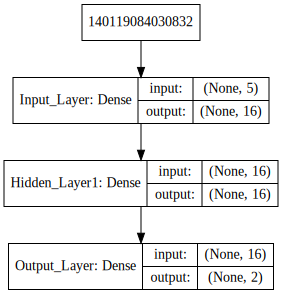

In [ ]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Cross-validate the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
model = KerasClassifier(build_fn=build_model, epochs=20, verbose=False)

cv = RepeatedStratifiedKFold(4, 3, random_state=13)
cv_results = cross_validate(model, X_train, y_train, scoring=['accuracy', 'precision', 'recall'], cv=cv, return_train_score=True);

In [ ]:
cv_metrics = pd.DataFrame(data=cv_results).drop(columns=['score_time', 'fit_time'])

### Show the results

In [ ]:
plt.figure(figsize=(7,7))

plt.plot(cv_metrics['test_accuracy'], color='Orange', linewidth=2)

plt.plot(cv_metrics['test_recall'], color='Red', linewidth=2)
plt.plot(cv_metrics['test_precision'], color='Blue', linewidth=2)

plt.axhline(cv_metrics['test_accuracy'].mean(), color='Orange', linewidth=1, linestyle='-.')
plt.axhline(cv_metrics['test_recall'].mean(), color='Red', linewidth=1, linestyle='-.')
plt.axhline(cv_metrics['test_precision'].mean(), color='Blue', linewidth=1, linestyle='-.')

plt.yticks(np.round(np.linspace(0.5, 0.8, 8), 2))
plt.title('Cross validation scores on test')
plt.xlabel('Step')
plt.legend(['Accuracy', 'Recall', 'Precision']);

In [ ]:

pd.DataFrame({
    'Mean':cv_metrics.mean(),
    'Standard Deviation':cv_metrics.std()
})


## Final prediction using test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=13)
model = build_model()
history = model.fit(X_train, y_train, epochs=50, verbose=False, validation_split=0.1)

In [ ]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

### Print the results

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 50, 4));
plt.title('Score on each iteration of the learning phase')
plt.legend(['Accuracy', 'Validation Accuracy']);

In [ ]:
print("Accuracy on train set: {}".format(accuracy_score(y_train[:,1], y_train_pred).round(3)))
print("Classification report on train set: ")
print(classification_report(y_train[:,1], y_train_pred))

In [ ]:
print("Accuracy on test set: {}".format(accuracy_score(y_test[:,1], y_test_pred).round(3)))
print("Classification report on test set: ")
print(classification_report(y_test[:,1], y_test_pred))

In [ ]:
cm_train = pd.DataFrame(confusion_matrix(y_train[:,1], y_train_pred), columns=['Predict no diabetes', 'Predict diabetes'],
                 index=['Diabetes', 'No diabetes'])

cm_test = pd.DataFrame(confusion_matrix(y_test[:,1], y_test_pred), columns=['Predict no diabetes', 'Predict diabetes'],
                 index=['Diabetes', 'No diabetes'])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax[0])
sns.heatmap(cm_train, annot=True, fmt='d')
plt.title('Train set')
plt.sca(ax[1])
sns.heatmap(cm_test, annot=True, fmt='d')
plt.title('Test set')

plt.suptitle('Confusion matrix')
plt.tight_layout()
plt.subplots_adjust(top=0.88)